<a href="https://colab.research.google.com/github/mark-morelos/DS-Unit-2-Applied-Modeling/blob/master/Copy_of_LS_DS_232_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 2*

---


# Wrangle ML datasets

- [ ] Continue to clean and explore your data. 
- [ ] For the evaluation metric you chose, what score would you get just by guessing?
- [ ] Can you make a fast, first model that beats guessing?

**We recommend that you use your portfolio project dataset for all assignments this sprint.**

**But if you aren't ready yet, or you want more practice, then use the New York City property sales dataset for today's assignment.** Follow the instructions below, to just keep a subset for the Tribeca neighborhood, and remove outliers or dirty data. [Here's a video walkthrough](https://youtu.be/pPWFw8UtBVg?t=584) you can refer to if you get stuck or want hints!

- Data Source: [NYC OpenData: NYC Citywide Rolling Calendar Sales](https://data.cityofnewyork.us/dataset/NYC-Citywide-Rolling-Calendar-Sales/usep-8jbt)
- Glossary: [NYC Department of Finance: Rolling Sales Data](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page)

In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [ ]:
# Read New York City property sales data
import pandas as pd
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

In [2]:
# using my project dataset
import pandas as pd
import numpy as np

shelter_outcome = pd.read_csv('sample_data/Animal_Shelter_Intake_and_Outcome.csv')
shelter_outcome.head()

,Name,Type,Breed,Color,Sex,Size,Date Of Birth,Impound Number,Kennel Number,Animal ID,Intake Date,Outcome Date,Days in Shelter,Intake Type,Intake Subtype,Outcome Type,Outcome Subtype,Intake Condition,Outcome Condition,Intake Jurisdiction,Outcome Jurisdiction,Outcome Zip Code,Location,Count
0,SKY,DOG,GERM SHEPHERD,BLACK/TAN,Female,MED,NaN,K20-035118,DS69,A395686,1/19/20,1/23/20,4,STRAY,FIELD,RETURN TO OWNER,OVER THE COUNTER_CALL,HEALTHY,HEALTHY,COUNTY,COUNTY,95404.0,"95404(38.458384, -122.675588)",1
1,COCO,DOG,BEAGLE,TRICOLOR,Neutered,SMALL,4/6/15,K17-025093,DS83,A379968,8/30/17,10/4/17,35,STRAY,FIELD,TRANSFER,NC AN FRND,UNKNOWN,HEALTHY,SANTA ROSA,OUT OF COUNTY,95758.0,"95758(38.424655, -121.438065)",1
2,BRATT,CAT,DOMESTIC SH,BRN TABBY,Spayed,SMALL,9/1/10,K18-028633,MAC,A374010,6/13/18,8/11/18,59,OWNER SURRENDER,OVER THE COUNTER,ADOPTION,MOB EVENT,TREATABLE/MANAGEABLE,HEALTHY,COUNTY,SANTA ROSA,95405.0,"95405(38.439152, -122.672541)",1
3,DOONA,DOG,PIT BULL,TAN/WHITE,Male,LARGE,7/6/16,K20-035573,DS67,A389249,3/11/20,3/13/20,2,STRAY,FIELD,RETURN TO OWNER,OVER THE COUNTER_NOTICE,HEALTHY,HEALTHY,SANTA ROSA,SANTA ROSA,95409.0,"95409(38.458965, -122.630156)",0
4,SUZIE,DOG,LABRADOR RETR/MIX,BLACK,Spayed,LARGE,1/23/11,K15-012348,DA34,A315553,1/7/15,1/24/15,17,STRAY,OVER THE COUNTER,ADOPTION,INTERNET,HEALTHY,HEALTHY,SANTA ROSA,SANTA ROSA,95404.0,"95404(38.458384, -122.675588)",1


Your code starts here:

In [3]:
# Change column names: replace spaces with underscores
shelter_outcome.columns = shelter_outcome.columns.str.replace(' ','_')
shelter_outcome.head(3)

,Name,Type,Breed,Color,Sex,Size,Date_Of_Birth,Impound_Number,Kennel_Number,Animal_ID,Intake_Date,Outcome_Date,Days_in_Shelter,Intake_Type,Intake_Subtype,Outcome_Type,Outcome_Subtype,Intake_Condition,Outcome_Condition,Intake_Jurisdiction,Outcome_Jurisdiction,Outcome_Zip_Code,Location,Count
0,SKY,DOG,GERM SHEPHERD,BLACK/TAN,Female,MED,NaN,K20-035118,DS69,A395686,1/19/20,1/23/20,4,STRAY,FIELD,RETURN TO OWNER,OVER THE COUNTER_CALL,HEALTHY,HEALTHY,COUNTY,COUNTY,95404.0,"95404(38.458384, -122.675588)",1
1,COCO,DOG,BEAGLE,TRICOLOR,Neutered,SMALL,4/6/15,K17-025093,DS83,A379968,8/30/17,10/4/17,35,STRAY,FIELD,TRANSFER,NC AN FRND,UNKNOWN,HEALTHY,SANTA ROSA,OUT OF COUNTY,95758.0,"95758(38.424655, -121.438065)",1
2,BRATT,CAT,DOMESTIC SH,BRN TABBY,Spayed,SMALL,9/1/10,K18-028633,MAC,A374010,6/13/18,8/11/18,59,OWNER SURRENDER,OVER THE COUNTER,ADOPTION,MOB EVENT,TREATABLE/MANAGEABLE,HEALTHY,COUNTY,SANTA ROSA,95405.0,"95405(38.439152, -122.672541)",1


In [5]:
# column to be used for predictive model
shelter_outcome['Outcome_Type'].describe()
shelter_outcome['Outcome_Type'].value_counts(normalize=True)
shelter_outcome = shelter_outcome.dropna(subset=['Outcome_Type'])
shelter_outcome['Outcome_Type'].isnull().sum()

# add a boolean column for True if ADOPTION and False if not for 'Outcome_Type'
shelter_outcome['Adopted'] = shelter_outcome['Outcome_Type'] == 'ADOPTION'
shelter_outcome['Adopted'].head(5)

# target distribution
y = shelter_outcome['Adopted']
y.value_counts(normalize=True)

# data exploration on Intake Type
shelter_outcome['Intake_Type'].unique()

# high cardinality features
shelter_outcome = shelter_outcome.drop(columns=['Name', 'Impound_Number', 'Kennel_Number',
                                                'Animal_ID', 'Color', 'Location'])

# fill missing values
shelter_outcome = shelter_outcome.fillna('No Data')

# time-based split using 'Intake_Date'
# convert to datetime

shelter_outcome['Intake_Date'] = pd.to_datetime(shelter_outcome['Intake_Date'])

# create 'Intake_Year' column
shelter_outcome['Intake_Year'] = shelter_outcome['Intake_Date'].dt.year 

# split to training: 2013-2015, val: 2016-2018, test: 2019-2020
train = shelter_outcome[shelter_outcome['Intake_Year'] <= 2015]
val = shelter_outcome[(shelter_outcome['Intake_Year'] >= 2016) & (shelter_outcome['Intake_Year'] >= 2018)]
test = shelter_outcome[shelter_outcome['Intake_Year'] >=2019]

# shape of dataframes
train.shape, val.shape, test.shape

((6533, 20), (6706, 20), (3629, 20))

In [12]:
%pip install --upgrade category_encoders

     |████████████████████████████████| 81kB 3.1MB/s 


In [15]:
# evaluation metric = accuracy

import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

# target
target = 'Adopted'

# set features
features = train.columns.drop([target, 'Intake_Date', 'Intake_Year', 'Outcome_Type'])

# define X_train, y_train, X_val, and y_val
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

# define pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    DecisionTreeClassifier(max_depth=3)
)

# run pipeline on training
pipeline.fit(X_train, y_train)

# print validation accuracy
print('Accuracy', pipeline.score(X_val, y_val))

Accuracy 0.904264837458992


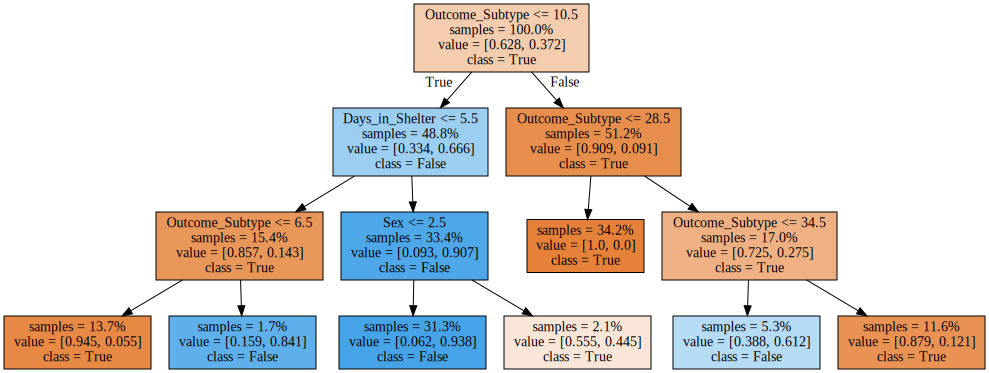

In [16]:
# visualize decision tree
import graphviz
from sklearn.tree import export_graphviz

tree = pipeline.named_steps['decisiontreeclassifier']

dot_data = export_graphviz(
    tree,
    out_file=None,
    feature_names=X_train.columns,
    class_names=y_train.unique().astype(str),
    filled=True,
    impurity=False,
    proportion=True
)

graphviz.Source(dot_data)

In [17]:
# distribution of classes
y.value_counts(normalize=True)

False    0.679252
True     0.320748
Name: Adopted, dtype: float64

In [18]:
# calculate ROC AUC with sklearn
from sklearn.metrics import roc_auc_score

# predicted probabilities
y_pred_proba = pipeline.predict_proba(X_val)[:, -1]

# calculate AUC
auc = roc_auc_score(y_val, y_pred_proba)

auc

0.9425365753168826

In [19]:
# calculate True Positive Rate (TPR) & False Positive Rate (FPR) at various thresholds
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

# table results
pd.DataFrame({
    'False Positive Rate': fpr,
    'True Positive Rate': tpr,
    'Threshold': thresholds
})

,False Positive Rate,True Positive Rate,Threshold
0,0.000000,0.000000,1.938416
1,0.066774,0.812100,0.938416
2,0.071185,0.842350,0.840708
3,0.098456,0.912158,0.612069
4,0.165831,0.959860,0.445255
5,0.308201,0.962769,0.120894
6,0.516342,1.000000,0.054871
7,1.000000,1.000000,0.000000


In [22]:
# plot results (ROC Curve)
import matplotlib.pyplot as plt
plt.scatter(fpr, tpr)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

In [ ]:
# Keep just the subset of data for the Tribeca neighborhood
# Check how many rows you have now. (Should go down from > 20k rows to 146)


In [ ]:
# Q. What's the date range of these property sales in Tribeca?


In [ ]:
# The Pandas Profiling Report showed that SALE_PRICE was read as strings
# Convert it to integers


In [ ]:
# Q. What is the maximum SALE_PRICE in this dataset?


In [ ]:
# Look at the row with the max SALE_PRICE


In [ ]:
# Get value counts of TOTAL_UNITS
# Q. How many property sales were for multiple units?


In [ ]:
# Keep only the single units


In [ ]:
# Q. Now what is the max sales price? How many square feet does it have?


In [ ]:
# Q. How often did $0 sales occur in this subset of the data?

# There's a glossary here: 
# https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page

# It says:
# A $0 sale indicates that there was a transfer of ownership without a 
# cash consideration. There can be a number of reasons for a $0 sale including 
# transfers of ownership from parents to children. 



In [ ]:
# Look at property sales for > 5,000 square feet
# Q. What is the highest square footage you see?


In [ ]:
# What are the building class categories?
# How frequently does each occur?


In [ ]:
# Keep subset of rows:
# Sale price more than $0, 
# Building class category = Condos - Elevator Apartments

# Check how many rows you have now. (Should be 106 rows.)


In [ ]:
# Make a Plotly Express scatter plot of GROSS_SQUARE_FEET vs SALE_PRICE


In [ ]:
# Add an OLS (Ordinary Least Squares) trendline,
# to see how the outliers influence the "line of best fit"


In [ ]:
# Look at sales for more than $35 million

# All are at 70 Vestry Street
# All but one have the same SALE_PRICE & SALE_DATE
# Was the SALE_PRICE for each? Or in total?
# Is this dirty data?


In [ ]:
# Make a judgment call:
# Keep rows where sale price was < $35 million

# Check how many rows you have now. (Should be down to 90 rows.)


In [ ]:
# Now that you've removed outliers,
# Look again at a scatter plot with OLS (Ordinary Least Squares) trendline


In [ ]:
# Select these columns, then write to a csv file named tribeca.csv. Don't include the index.
